# <b> Project Introduction

#### The Indian education landscape has been undergoing rapid changes for the past 10 years owing to the advancement of web-based learning services, specifically, eLearning platforms.
#### Global E-learning is estimated to witness an 8X over the next 5 years to reach USD 2B in 2021. India is expected to grow with a CAGR of 44% crossing the 10M users mark in 2021. Although the market is growing on a rapid scale, there are major challenges associated with digital learning when compared with brick and mortar classrooms. One of many challenges is how to ensure quality learning for students. Digital platforms might overpower physical classrooms in terms of content quality but when it comes to understanding whether students are able to grasp the content in a live class scenario is yet an open-end challenge.
#### In a physical classroom during a lecturing teacher can see the faces and assess the emotion of the class and tune their lecture accordingly, whether he is going fast or slow. He can identify students who need special attention. Digital classrooms are conducted via video telephony software program (ex-Zoom) where it’s not possible for medium scale class (25-50) to see all students and access the mood. Because of this drawback, students are not focusing on content due to lack of surveillance.
#### While digital platforms have limitations in terms of physical surveillance but it comes with the power of data and machines which can work for you. It provides data in the form of video, audio, and texts which can be analysed using deep learning algorithms. Deep learning backed system not only solves the surveillance issue, but it also removes the human bias from the system, and all information is no longer in the teacher’s brain rather translated in numbers that can be analysed and tracked.

# <b> Problem Statement

#### We will solve the above-mentioned challenge by applying deep learning algorithms to live video data. The solution to this problem is by recognizing the face, mark the attendance, log the individual’s session time and put a drowsiness alert.

#### **Face Recognition**
####This is a few shot learning live face attendance systems. The model should be able to real-time identify attending students in the live class based on few images of students.

#### **Drowsiness Detector**
#### This will detect facial landmarks and extract the eye regions. The algorithm should be able to identify students who are not attentive and drowsing in the class.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# ! pip install tensorflow tensorflow-gpu opencv-python 

In [ ]:
import cv2
import os 
import random
import numpy as np
import math
import matplotlib.pyplot as plt
import uuid
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

import keras
import tensorflow as tf
from keras.models import Model
from keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
from keras.metrics import Precision, Recall

In [ ]:
# Move LFW Images to the following repository data/negative
# for directory in os.listdir('/content/drive/MyDrive/Colab Notebooks/AlmaBetter Notebooks/Capstone projects/Face Recognition and Drowsiness Detection - Selva Subramanian S/Dataset/lfw.tgz (Unzipped Files)/lfw'):
#     for file in os.listdir(os.path.join('/content/drive/MyDrive/Colab Notebooks/AlmaBetter Notebooks/Capstone projects/Face Recognition and Drowsiness Detection - Selva Subramanian S/Dataset/lfw.tgz (Unzipped Files)/lfw', directory)):
#         EX_PATH = os.path.join('/content/drive/MyDrive/Colab Notebooks/AlmaBetter Notebooks/Capstone projects/Face Recognition and Drowsiness Detection - Selva Subramanian S/Dataset/lfw.tgz (Unzipped Files)/lfw', directory, file)
#         NEW_PATH = os.path.join('/content/drive/MyDrive/Colab Notebooks/AlmaBetter Notebooks/Capstone projects/Face Recognition and Drowsiness Detection - Selva Subramanian S/Dataset/Negative', file)
#         os.replace(EX_PATH, NEW_PATH)

In [ ]:
# Use uuid library to generate unique image names in Anchor
os.path.join('D:\Selva\Capstone Projects\5 DL & MLE\FaceRecognition & DrowsinessDetection\Anchor', '{}.jpg'.format(uuid.uuid1()))

# Establish a connection to the webcam
cap = cv2.VideoCapture(0)
print("[INFO] Press q to exit webcam")
while True: 
    ret, frame = cap.read()
   
    # Cut down frame to 250x250px
    frame = frame[120:120+250,200:200+250, :]

    # Collect anchors 
    if cv2.waitKey(1) & 0XFF == ord('a'):
        # Create the unique file path 
        imgname = os.path.join('D:/Selva/Capstone Projects/5 DL & MLE/FaceRecognition & DrowsinessDetection/Anchor', '{}.jpg'.format(uuid.uuid1()))
        # Write out anchor image
        cv2.imwrite(imgname, frame)
    
    # Collect positives
    if cv2.waitKey(1) & 0XFF == ord('p'):
        # Create the unique file path 
        imgname = os.path.join('D:/Selva/Capstone Projects/5 DL & MLE/FaceRecognition & DrowsinessDetection/Positive', '{}.jpg'.format(uuid.uuid1()))
        # Write out positive image
        cv2.imwrite(imgname, frame)
    
    # Show image back to screen
    cv2.imshow('Image Collection', frame)
    
    # Breaking gracefully
    if cv2.waitKey(1) & 0XFF == ord('q'):
        break
        
# Release the webcam
cap.release()
# Close the image show frame
cv2.destroyAllWindows()

[INFO] Press q to exit webcam


TypeError: ignored

### <b> Building TensorFlow Input Pipeline

In [ ]:
anchor = tf.data.Dataset.list_files('/content/drive/MyDrive/Colab Notebooks/AlmaBetter Notebooks/Capstone projects/Face Recognition and Drowsiness Detection - Selva Subramanian S/Dataset/Anchor'+'/*.jpg').take(100)
positive = tf.data.Dataset.list_files('/content/drive/MyDrive/Colab Notebooks/AlmaBetter Notebooks/Capstone projects/Face Recognition and Drowsiness Detection - Selva Subramanian S/Dataset/Positive'+'/*.jpg').take(100)
negative = tf.data.Dataset.list_files('/content/drive/MyDrive/Colab Notebooks/AlmaBetter Notebooks/Capstone projects/Face Recognition and Drowsiness Detection - Selva Subramanian S/Dataset/Negative'+'/*.jpg').take(100)

In [ ]:
dir_test = anchor.as_numpy_iterator()
dir_test.next()

b'/content/drive/MyDrive/Colab Notebooks/AlmaBetter Notebooks/Capstone projects/Face Recognition and Drowsiness Detection - Selva Subramanian S/Dataset/Anchor/0559a06b-a430-11ec-8bfd-d3d452b647c6.jpg'

(250, 250, 3)


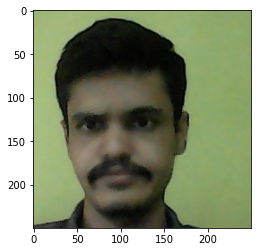

In [ ]:
img = plt.imread('/content/drive/MyDrive/Colab Notebooks/AlmaBetter Notebooks/Capstone projects/Face Recognition and Drowsiness Detection - Selva Subramanian S/Dataset/Anchor/0422b17b-a430-11ec-83f2-d3d452b647c6.jpg')
plt.imshow(img)
print(img.shape)

In [ ]:
def preprocess(file_path):
  # read image from file path
  byte_img = tf.io.read_file(file_path)
  # load the image
  img = tf.io.decode_jpeg(byte_img)
  # resize the image to be 105x105x3
  img = tf.image.resize(img,(105,105))
  # scale the image between 0 to 1
  img = img/255.0
  return img

In [ ]:
img = preprocess('/content/drive/MyDrive/Colab Notebooks/AlmaBetter Notebooks/Capstone projects/Face Recognition and Drowsiness Detection - Selva Subramanian S/Dataset/Anchor/0422b17b-a430-11ec-83f2-d3d452b647c6.jpg')

In [ ]:
# anchor = anchor.map(preprocess)
# positive = positive.map(preprocess)
# negative = negative.map(preprocess) 

(105, 105, 3)


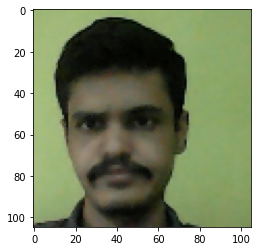

In [ ]:
plt.imshow(img)
print(img.shape)

In [ ]:
positives = tf.data.Dataset.zip((anchor,positive,tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor,negative,tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [ ]:
samples = data.as_numpy_iterator()

In [ ]:
example = samples.next()

In [ ]:
example

(b'/content/drive/MyDrive/Colab Notebooks/AlmaBetter Notebooks/Capstone projects/Face Recognition and Drowsiness Detection - Selva Subramanian S/Dataset/Anchor/010bba6f-a430-11ec-b26e-d3d452b647c6.jpg',
 b'/content/drive/MyDrive/Colab Notebooks/AlmaBetter Notebooks/Capstone projects/Face Recognition and Drowsiness Detection - Selva Subramanian S/Dataset/Positive/1ee25f76-a430-11ec-bc7d-d3d452b647c6.jpg',
 1.0)

### <b> Train Test Split

In [ ]:
def preprocess_twin(input_img, validation_img, label):
  return(preprocess(input_img),preprocess(validation_img),label)

In [ ]:
# Build dataloader pipeline
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=100)

In [ ]:
# Training partition
train_data = data.take(round(len(data)*0.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [ ]:
# Testing partition
test_data = data.skip(round(len(data)*0.7))
test_data = test_data.take(round(len(data)*0.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

### <b> Model Building

#### <b> Embeddings

In [ ]:
def make_embeddings():
  inp = Input(shape=(105,105,3),name='input image')

  # 1st block
  c1 = Conv2D(64,(10,10),activation='relu')(inp)
  m1 = MaxPooling2D(64,(2,2),padding='same')(c1)

  # 2nd block
  c2 = Conv2D(128,(7,7),activation='relu')(m1)
  m2 = MaxPooling2D(64,(2,2),padding='same')(c2)

  # 3rd block
  c3 = Conv2D(128,(4,4),activation='relu')(m2)
  m3 = MaxPooling2D(64,(2,2),padding='same')(c3)

  # final block
  c4 = Conv2D(256,(4,4),activation='relu')(m3)
  f1 = Flatten()(c4)
  d1 = Dense(4096,activation='sigmoid')(f1)

  return Model(inputs=[inp], outputs=[d1], name='embeddings')

In [ ]:
embedding = make_embeddings()

In [ ]:
embedding.summary()

Model: "embeddings"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input image (InputLayer)    [(None, 105, 105, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 96, 96, 64)        19264     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 48, 48, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 42, 42, 128)       401536    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 21, 21, 128)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 18, 18, 128)       2

#### <b> Distance Layer

In [ ]:
# Siamese L1 Distance class
class L1Dist(Layer):
  def __init__(self,**kwarg):
    super().__init__()
  def call(self,input_embedding, validation_embedding):
    return tf.math.abs(input_embedding-validation_embedding)

#### <b> Siamese model

In [ ]:
def siamese_model():
  
  # anchor image
  input_image = Input(shape=(105,105,3),name='input_img')
  
  # validation image
  validation_image = Input(shape=(105,105,3),name='validation_img')

  # combine distances
  siamese_layer = L1Dist()
  siamese_layer._name = 'distance'
  distances = siamese_layer(embedding(input_image), embedding(validation_image))

  # classification
  classifier = Dense(1,activation='sigmoid')(distances)

  return Model(inputs=[input_image,validation_image], outputs=classifier, name='SiameseNetwork') 

In [ ]:
siamese_model = siamese_model()

In [ ]:
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 105, 105, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 105, 105, 3  0           []                               
                                )]                                                                
                                                                                                  
 embeddings (Functional)        (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validation_img[0][

### <b> Training

In [ ]:
# setup loss
binary_cross_loss = tf.losses.BinaryCrossentropy()

# optimizer
opt = tf.keras.optimizers.Adam(1e-4)

In [ ]:
# establish checkpoints
checkpoint_dir = '/content/drive/MyDrive/Colab Notebooks/AlmaBetter Notebooks/Capstone projects/Face Recognition and Drowsiness Detection - Selva Subramanian S/training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir,'checkpoint')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)

In [ ]:
# train step function
test_batch = train_data.as_numpy_iterator()
batch1 = test_batch.next()

In [ ]:
@tf.function
def train_step(batch):
  
  # to record
  with tf.GradientTape() as tape:
  
    # get anchor & positive/negative images
    X = batch[:2]
    y = batch[2]

    # forward propagation
    yhat = siamese_model(X, training=True)
    # calculate loss
    loss = binary_cross_loss(y, yhat)
  print(loss)

  # calculate gradients
  grad = tape.gradient(loss, siamese_model.trainable_variables)

  # apply updated weigths to siamese model
  opt.apply_gradients(zip(grad, siamese_model.trainable_variables))

  return loss

In [ ]:
def train(data,EPOCHS):
  # loop through each epoch
  for epoch in range(1, EPOCHS+1):
    print('\n Epoch {}/{}'.format(epoch,EPOCHS))
    progbar = tf.keras.utils.Progbar(len(data))

    r = Recall()
    p = Precision()

    # loop through each batch
    for idx, batch in enumerate(data):
      loss = train_step(batch)
      yhat = siamese_model.predict(batch[:2])
      r.update_state(batch[2],yhat)
      p.update_state(batch[2],yhat)
      progbar.update(idx+1)
    print(loss.numpy(),r.result().numpy(),p.result().numpy())

    # Save checkpoints
    if epoch % 10 == 0: 
      checkpoint.save(file_prefix=checkpoint_prefix)

### <b> Model Training

In [ ]:
EPOCHS = 1
train(train_data,EPOCHS)


 Epoch 1/1
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
9/9 [==============================] - 381s 41s/step
0.40118065 0.5194805 0.9756098


In [ ]:
# evaluation metrics
r = Recall()
p = Precision()

In [ ]:
for test_input, test_val, y_true in test_data.as_numpy_iterator():
  yhat = siamese_model.predict([test_input,test_val])
  r.update_state(y_true,yhat)
  p.update_state(y_true,yhat)
print(r.result().numpy(),p.result().numpy())

0.10714286 1.0


1.0


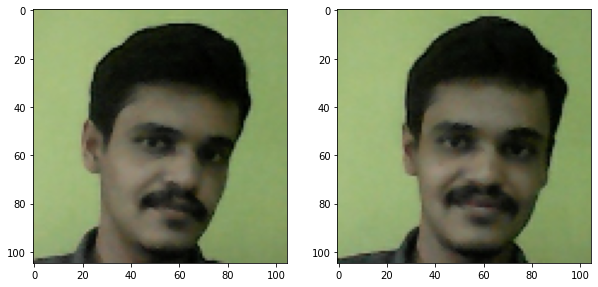

In [ ]:
# Set plot size 
plt.figure(figsize=(10,8))

# Set first subplot
plt.subplot(1,2,1)
plt.imshow(test_input[0])

# Set second subplot
plt.subplot(1,2,2)
plt.imshow(test_val[0])
print(y_true[0])

# Renders cleanly
plt.show()